# Task 3
In this task we produce the plots as shown in the project guideline.

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
import sklearn.gaussian_process.kernels as k
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

from itertools import product
from IPython.display import clear_output
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=2)

import matplotlib.pyplot as plt
%matplotlib inline

We organize data in the following format as a dictionary (it's pretty crazy looking, not going to lie).
```
err_dict = {
    'rana': {
        'tree': {
            'CELL_H': [...],
            'CELL_D': [...],
            ...
        },
        'svr': {
            'CELL_H': [...],
            ...
        }
    },
    'dossantos': {
        ...
    }
}
```
The keys of the outermost layer are `rana`, `dossantos`, `moonchai`, `precharattana`. The keys one layer in are `tree`, `svr`, and `gpr`. Finally, the inner most keys are `CELL_H`, `CELL_D`, `CELL_A1`, `CELL_A2`.

## Init Stuff, Helper Stuff, Not Important Stuff
Here defines some stuff that are used in the main loop later on. The comments hopefully are descriptive enough.

In [2]:
def load_data(model):
    """ Helper function to load processed spreadsheet.

    This function drops useless columns and converts all cell counts
    to percentages.
    """
    
    data = pd.read_csv('clean_data/{}.csv'.format(model))
    
    # Convert cell counts to percentages
    data['_N_CELLS'] = data['L'] ** 2
    for col in ['CELL_H', 'CELL_D', 'CELL_A1', 'CELL_A2']:
        data[col] = data[col] / data['_N_CELLS']
    
    # Drop useless columns. Incidentally, CELL_N is always zero
    # for all 900 runs for the moonchai model, so we drop that
    # column as well
    data = data.drop(['Model', 'Run', 'L', 'CELL_N', '_N_CELLS'], axis=1)
    
    return data

In [4]:
# List of regressor objects the loop will use. This is the only place
# that needs to be changed if a new regressor needs to be used.
regressors = {
    'tree': DecisionTreeRegressor(min_samples_leaf=2),
    
    'svr': Pipeline([
        ('scale', StandardScaler()),
        
        # LinearSVR seems to have worse convergence properties than SVR.
        # Since our dataset is small, we can afford to use SVR. 
        # Epsilon is set to low since the targets \in [0, 1].
        ('svr', SVR(kernel='poly', degree=1, epsilon=1e-3))
    ]),
    
    'gpr': gpr(kernel=k.RationalQuadratic(alpha=.1, length_scale=1))
}

# Sets up an empty dictionary for storage.
err_dict = {
    'rana': {},
    'dossantos': {},
    'moonchai': {},
    'precharattana': {}
}

## Main Calculation Loop
The cell below executes the regressors on various columns, and stores results in the format specified at the beginning of the script. For reference, it is also copied below --
```
err_dict = {
    'rana': {
        'tree': {
            'CELL_H': [...],
            'CELL_D': [...],
            ...
        },
        'svr': {
            'CELL_H': [...],
            ...
        }
    },
    'dossantos': {
        ...
    }
}
```

In [5]:
# Generates pairs of configurations (model name, name of regressor to run)
# Using this instead of nested for loops because double indentations just
# to get the loop running is pretty nasty looking.
configs = list(product(
    ['rana', 'dossantos', 'moonchai', 'precharattana'],
    list(regressors.keys())
))

Unfortunately the computation complexity of this loop is pretty high. Since the computation can be trivially parallelized based on model (and regressors in fact, but there will be an race condition to write to the dictionary), we will move all the code above and below to a python script that executes these code in parallel. The result will be dumped to to a JSON file so we can read it in for plotting.

In [ ]:
# Main loop that loops through all models and regressors, and performs
# all necessary computations.

for config in configs:
    # Expands the ordered pair and extract model and regressor_name
    # and also grabs the regressor object
    model, regressor_name = config
    regressor = regressors[regressor_name]
    
    # Load data and create a new entry for the model in err_dict
    data = load_data(model)
    err_dict[model][regressor_name] = {}
    
    # Class columns and feature columns
    y_cols = ['CELL_H', 'CELL_D', 'CELL_A1', 'CELL_A2']
    X_cols = [col for col in data.columns if col not in y_cols]
    
    for col in y_cols:        
        # Printing progress so we have an idea where we are
        clear_output(wait=True)
        print('Now calculating', model, 'model with regressor', 
              regressor_name, 'on', col)
        
        # Stores the average of the cv scores, will be saved
        # to err_dict
        errors = []
        
        y = data[col]
        
        for t in range(1, 42):
            # Prints progress :D
            print('#', end='')
            
            # Grabbing features up to t = some multiple of five
            # This 20 here is because we have 20 features for each
            # time step.
            this_X_cols = X_cols[:20*t]
            X = data[this_X_cols]
            
            scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=10)
            errors.append(np.average(np.sqrt(-scores)))
        
        # Saves error to the appropriate place
        err_dict[model][regressor_name][col] = errors

clear_output(wait=True)
print('Done!')

## Plotting
For each model, we generate a plot of 4 subplots.

In [11]:
import json
with open('res.json') as f: err_dict = json.load(f)

In [13]:
# A look up table to get beautified names of terms in the output graphs
beautiful_names = {
    'rana': 'Rana Model',
    'dossantos': 'Dos Santos Model',
    'moonchai': 'Moonchai Model',
    'precharattana': 'Precharattana Model',
    'tree': 'Decision Tree',
    'svr': 'SVR (Linear)',
    'gpr': 'GPR (RQ)'
}

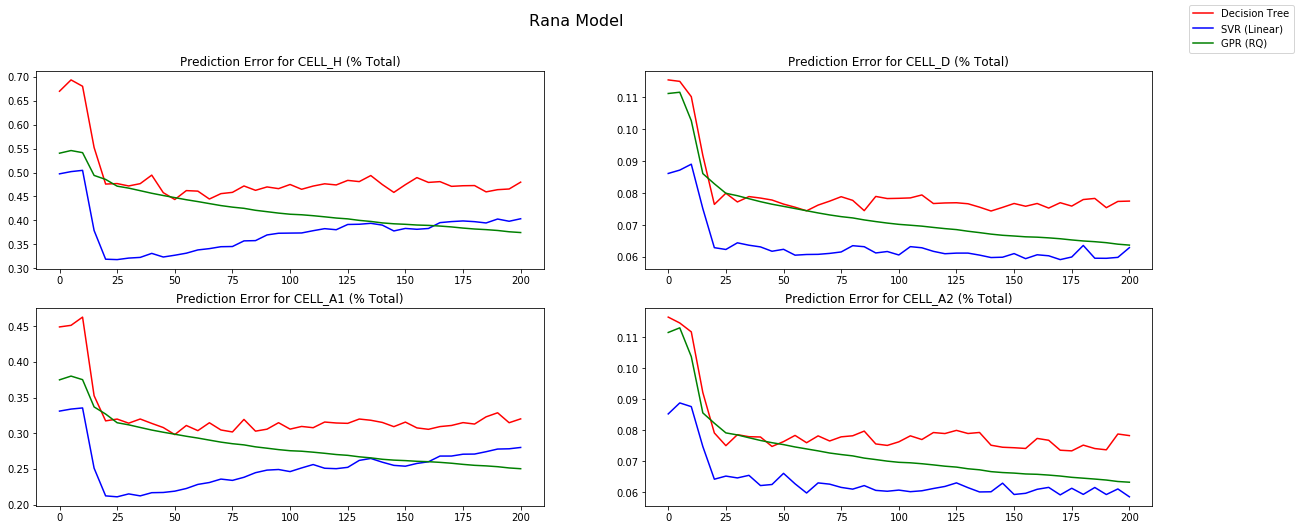

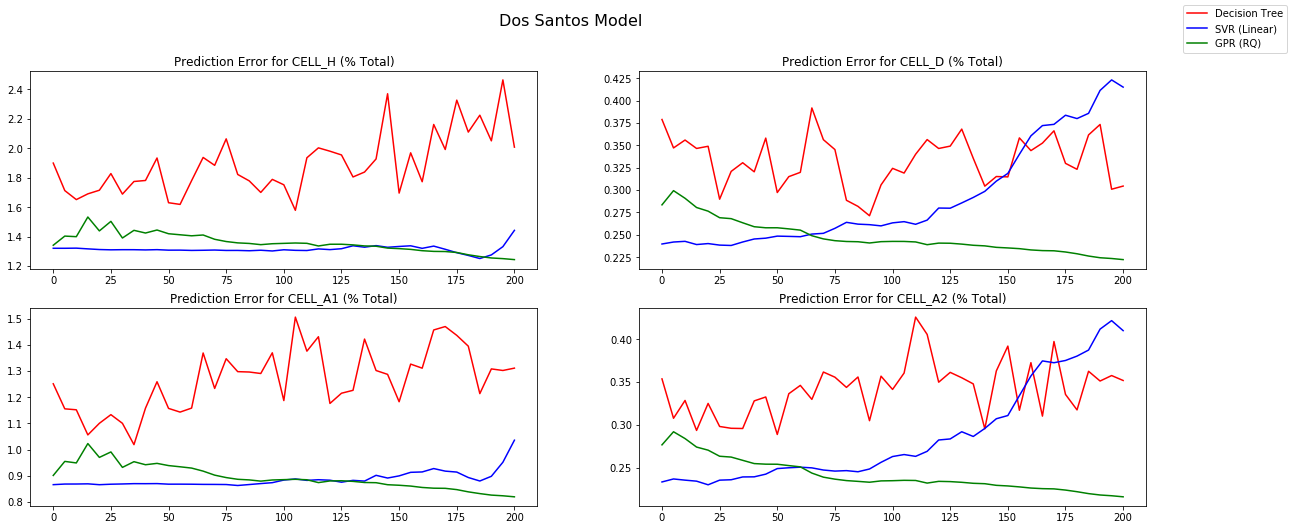

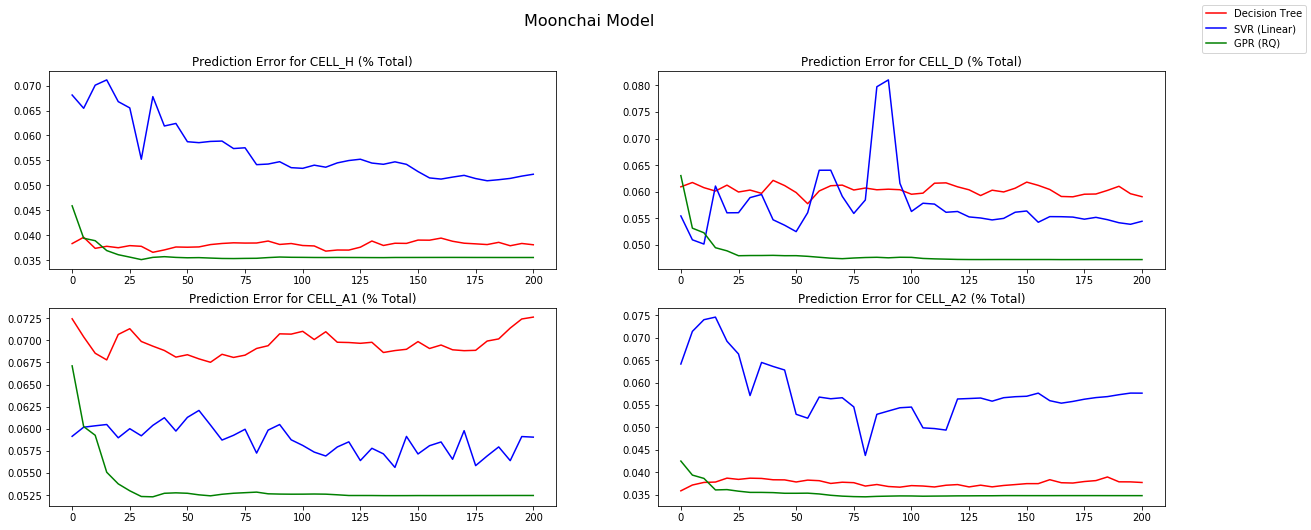

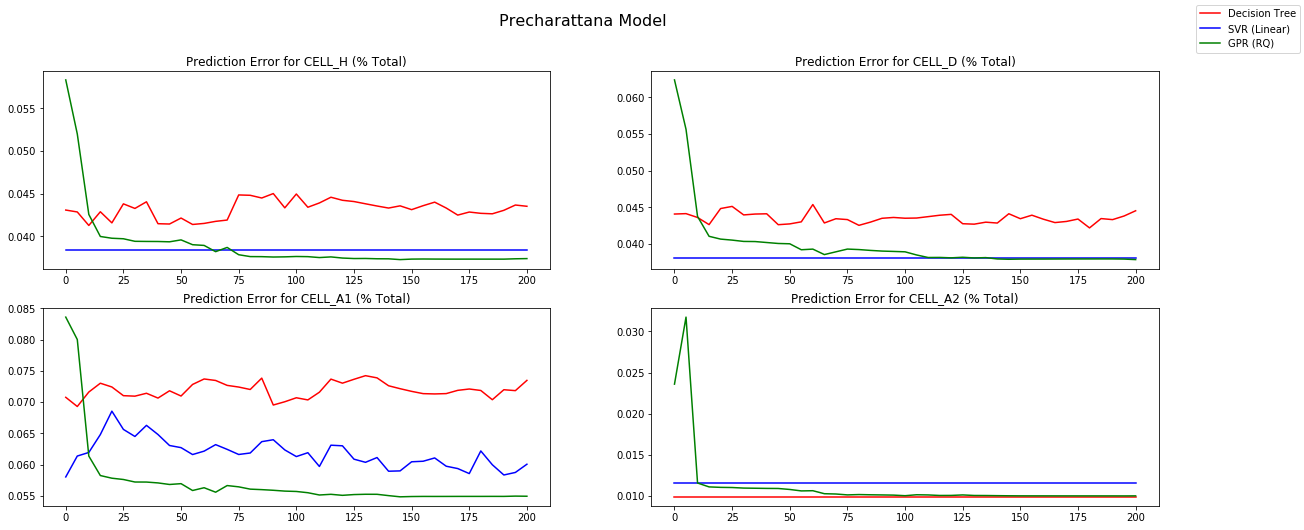

In [15]:
for model in ['rana', 'dossantos', 'moonchai', 'precharattana']:
    # Refer back to the structure of err_dict, we are getting all the
    # data pertaining to the given model.
    plot_data = err_dict[model]
    
    # Set up matplotlib stuff for plotting. Also set up a master
    # title for the series of graphs.
    fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    fig.suptitle(beautiful_names[model], fontsize=16)
    axs = axs.flat

    # We plot the attr plot on axis ax
    for ax, attr in zip(axs, ['CELL_H', 'CELL_D', 'CELL_A1', 'CELL_A2']):
        # Each color corresponds to the data of a regressor
        colors = ['r', 'b', 'g']
        
        # For reach regressor, plot the data with color color.
        for regressor_name, color in zip(plot_data.keys(), colors):
            ax.plot(
                range(0, 201, 5),  # These are the time steps
                # Scale by 100 to get percentages
                list(map(lambda x : 100 *x ,plot_data[regressor_name][attr])),
                c = color, label=beautiful_names[regressor_name]
            )
        
        # Set subfigure title and enable legends
        ax.set_title('Prediction Error for ' + attr + ' (% Total)')
#         ax.legend()
    
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels)
    
    fig.savefig(model + '.png')
    plt.show()